<a href="https://colab.research.google.com/github/woon0505/AI6124_A4/blob/main/ai6124_assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI6124 Assignment 4

Created by A/Prof Kai Keng ANG (kkang@i2r.a-star.edu.sg, kkang@ntu.edu.sg). Last modified 21 Oct 2024

Submitted by: [Woon Khai SHen] Mat ID: [G2304398L]

# Instructions

Enter your name according to NTU Learn, and your student ID above. Do not include the square brackets. Please save the file as POPFNN_[Student name].ipynb and submit in NTU Learn.

There are 9 questions in this assignment. Some questions have multiple parts, and the last question has 2 marks. Please read the question and hints carefully. This assignment has more open ended questions than Assignment 3. Code for some of the questions are also to be in the POPFNN class, not just below the question. So read carefully.

# Objective
In this tutorial, you will implement derivation of fuzzy if-then rules using Pseudo Outer Product (POP) Learning in POPFNN.

After completing this tutorial, you will know:

* How to apply what you leaned in the previous AI6124 assignment 3 to implement membership functions
* How to code a function to generate a given number of membership functions that span the input space of the data
* How to apply Learning Vector Quantization (LVQ), a clustering algorithm to generate interpretable membership functions from the dataset
* How to implement a simple fuzzy rule identification Pseudo Outer-Product (POP) learning algorithm to identify if-then-fuzzy rules using the generated membership functions and the dataset
* How to optimize the if-then-fuzzy rules identified

Prerequisites:
1. Python programming. https://docs.python.org/3/tutorial/.
2. Completion and understanding of AI6124 Assignment 3
3. Fuzzylab
4. AI6124 Lectures 9, 10, 11

Feel free to edit and use some code from this notebook for your group project, but please remove the assignment questions and your answers.

# Introduction

First we install the Fuzzy Logic libraries, and import the necessary libraries.

In [ ]:
!pip install -U fuzzylab
import numpy as np
import matplotlib.pyplot as plt
from random import seed
import sys
import fuzzylab as fz


# 1. Fuzzy Membership and NFS basics

In order to use Fuzzy Membership functions and a Neuro-Fuzzy System such as POPFNN, we need to create the basic functions and classes to store the parameters.

In this tutorial, we will use the Guassian 2mf membership function. This function has 2 parameters more than the Gaussian membership function. Both are provided for reference. An evalmf function is also included to call the respective function to evaluate a membership output.

In [ ]:
def gaussmf(x, params):
    assert len(params) == 2, 'Gaussmf function must have 2 parameters.'
    sig, c = np.asarray(params)
    return np.exp(-pow((x - c), 2) / (2 * pow(sig, 2)))

def gauss2mf(x, params):
    assert len(params) == 4, 'Gauss2mf function must have 4 parameters.'
    sig1, c1, sig2, c2 = np.asarray(params)
    assert c1 <= c2, 'c1 <= c2 is required.'
    if np.isscalar(x):
        if x<=c1:
            y=gaussmf(x, [sig1, c1])
        else:
            y=gaussmf(x,[sig2, c2])
    else:
        y = np.ones(len(x))
        idx1 = (x <= c1)
        idx2 = (x > c2)
        y[idx1] = gaussmf(x[idx1], [sig1, c1])
        y[idx2] = gaussmf(x[idx2], [sig2, c2])
    return y

# This function overwrites the evalmf function of the fuzzy logic toolbox by looking for the function name defined by
# mf.Type and calling it directly.
def evalmf(mf, x):
    possibles = globals().copy()
    possibles.update(locals())
    method = possibles.get(mf.Type)
    return method(x, mf.Parameters)

## Fuzzy Membership Function and POPFNN classes

Next we create a Fuzzy Membership function class to store the Fuzzy Membership function created, and a POPFNN class to store the input, output and fuzzy rules created.

In [ ]:
class fuzzymf(object):
    def __init__(self, Type, Parameters):
        self.Type = Type
        self.Parameters = Parameters
    def __repr__(self):
            return 'fismf, '\
                ' Type: %s, '\
                ' Parameters: %s\n'\
                % (self.Type,self.Parameters)

class popfnn(object):
    In_mf:fuzzymf
    Out_mf:fuzzymf
    N_inputs:int
    N_outlabels:int
    Lut_m:np
    Lut_d:np
    N_rules:int
    Pweights:np

    def __init__(self, In_mf, Out_mf):
        self.In_mf = In_mf
        self.Out_mf = Out_mf

        self.N_inputs=len(self.In_mf)
        self.N_outlabels=len(self.Out_mf[0])
        self.Lut_m=np.empty(self.N_inputs, np.int8)
        self.Lut_d=np.empty(self.N_inputs, np.int8)

        # Calculate lookup tables for rule access
        self.N_rules = 1
        for i in range(self.N_inputs):
            self.Lut_m[i] = len(self.In_mf[i]) #n_mf
            self.Lut_d[i] = 1
            self.N_rules = self.N_rules * self.Lut_m[0]
            for j in range(i):
                self.Lut_d[j] = self.Lut_d[j] * self.Lut_m[j]

        # Initialize pseudo weights for all rules
        self.pweights = np.zeros([self.N_rules,self.N_outlabels])

    # returns the membership label given rule number and the ninput
    def getlabel(self, rule, ninput):
        return ( int((int(rule)/(self.Lut_d[ninput]))%self.Lut_m[ninput]));

    # prints all the rules
    def printruleslabels(self):
        print('N_inputs=',self.N_inputs)
        print('N_rules=',self.N_rules)
        print('N_output_mf=',self.N_outlabels)
        print('rule_number, labels, pweights')
        for i in range(self.N_rules):
            print(i,end = ' ')
            for j in range(self.N_inputs):
                print(self.getlabel(i,j),end = ' ')
            for j in range(self.N_outlabels):
                print(self.pweights[i][j],end = ' ')
            print(' ')

    # Enter code for question 8 here for print_int_labels
    def print_int_labels(self):
      for i in range(self.N_rules):
        consequent = np.argmax(self.pweights[i])
        print("Rule", i, end =":")
        print("if X1 is" ,self.getlabel(i,0), end=" and ")
        print("X2 is" ,self.getlabel(i,1), end=" then ")
        print("y is", consequent+1)


    def poplearn(self, x, y):
        for r in range(self.N_rules):
            min_t=1.0
            for i in range(self.N_inputs):
                # Get the label of input i for rule r
                label=self.getlabel(r,i)
                # Compute membership of input i
                t=evalmf(self.In_mf[i][label],x[i])
                # Compute min across all input membership functions
                min_t=min(min_t,t)
            for i in range(self.N_outlabels):
                t=evalmf(self.Out_mf[0][i],y)
                self.pweights[r][i]+=min_t*t

    # Enter code for question 5 here for function identify_rules
    def identify_rules(self):
      # print(self.Out_mf)
      for i in range(self.N_rules):
        print("rule number: ", i, end =", ")

        consequent = np.argmax(self.pweights[i])
        print(f"consequents: Y{consequent+1}")

    # Enter code for question 9 here for function poppredict(self, x) and return predicted y
    def poppredict(self, x):
      pred = []
      for data in x:
        for i in range(self.N_rules):
          consequent = np.argmax(self.pweights[i])
          if (self.pweights[i][0] > 1.25 * self.pweights[i][1]) or (self.pweights[i][1] > 1.25 * self.pweights[i][0]):
            sup1 = evalmf(self.In_mf[0][self.getlabel(i,0)], self.In_mf[0][self.getlabel(i,0)].Parameters[3]+self.In_mf[0][self.getlabel(i,0)].Parameters[2])
            degree1 = evalmf(self.In_mf[0][self.getlabel(i,0)], data[0])
            sup2 = evalmf(self.In_mf[1][self.getlabel(i,1)], self.In_mf[1][self.getlabel(i,1)].Parameters[3]+self.In_mf[1][self.getlabel(i,1)].Parameters[2])
            degree2 = evalmf(self.In_mf[1][self.getlabel(i,1)], data[1])
            if (degree1>=sup1 and degree2>=sup2):
              pred.append(consequent+1)
            else:
              pred.append(2-consequent)
          else:
              pred.append(2-consequent)
        return pred


# 2. Generating Fuzzy Membership functions by spanning the input space

Next we create a simple function to generate a given number of membership functions that span the input space of the data.

In [ ]:
# This function creates nlabels number of gauss2mf that spans min and max of the inputs
def span_learnmem(x, params):

    assert len(params) == 2, 'spam_learnmem function must have 2 parameters.'
    nlabels, width = np.asarray(params)
    nlabels=int(nlabels)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)

    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)

    fis=[]
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
        sig=(centroids[1]-centroids[0])*width
        mf=[]
        for j in range(nlabels):
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)
    return fis


# 3. Generate Training dataset

Now we generate a dataset to train the Neuro Fuzzy System.

Text(0, 0.5, '$x_2$')

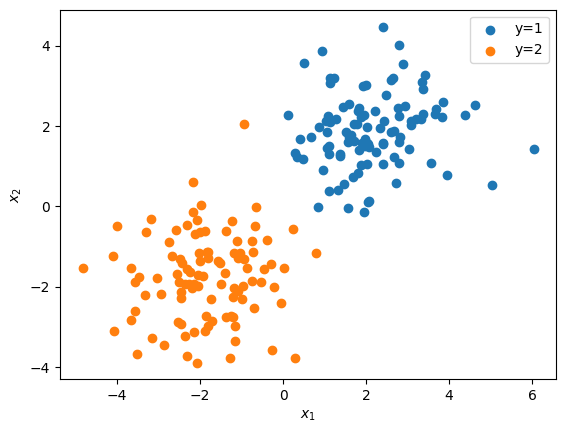

In [ ]:
seed(1)
dataset = np.random.randn(200,2)
dataset[0:100]+=(+2)
dataset[101:200]+=(-2)
labels=np.array([1]*100)
labels=np.append(labels,[2]*100)
#labels=labels.transpose()
plt.scatter(dataset[labels==1,0], dataset[labels==1,1])
plt.scatter(dataset[labels==2,0], dataset[labels==2,1])
plt.legend(['y=1','y=2'])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# 4. Train the fuzzy membership functions

Now we use the span_learnmem function to generate the fuzzy membership functions. After POPFNN initializes the rule space based on the input and output membership functions. The function printrulelabels prints out all the rules, the membership function labels for each input, and the pseudo weights of each rule.

In [ ]:
inmf = span_learnmem(dataset, [3, 0.5])
outmf = span_learnmem(labels, [3, 0.5])
nf=popfnn(In_mf=inmf, Out_mf=outmf)
nf.printruleslabels()

N_inputs= 2
N_rules= 9
N_output_mf= 3
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0  
1 0 1 0.0 0.0 0.0  
2 0 2 0.0 0.0 0.0  
3 1 0 0.0 0.0 0.0  
4 1 1 0.0 0.0 0.0  
5 1 2 0.0 0.0 0.0  
6 2 0 0.0 0.0 0.0  
7 2 1 0.0 0.0 0.0  
8 2 2 0.0 0.0 0.0  


<font color=red>Question 1(a)</font>: How many rules are initialized in the above code? <font color='red'>(0.5 mark)</font>

Enter your answer to Question 1(a) here.
Number of rules initialized = 9


<font color=red>Question 1(b)</font>: How many rules are generated if you change span_learnmem to generate 2 membership functions instead of 3 for both input and output membership functions? <font color=blue>Hint: Examine the code carefully. </font><font color='red'>(0.5 mark)</font>

In [ ]:
# Modify code for question 1(b) here
inmf2 = span_learnmem(dataset, [2, 0.5])
outmf2 = span_learnmem(labels, [2, 0.5])
nf2=popfnn(In_mf=inmf2, Out_mf=outmf2)
nf2.printruleslabels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 0.0 0.0  
1 0 1 0.0 0.0  
2 1 0 0.0 0.0  
3 1 1 0.0 0.0  


Enter your answer to Question 1(b) here. Number of rules initialized = 4


Text(0.5, 1.0, 'Membership Functions for Input $x_1$')

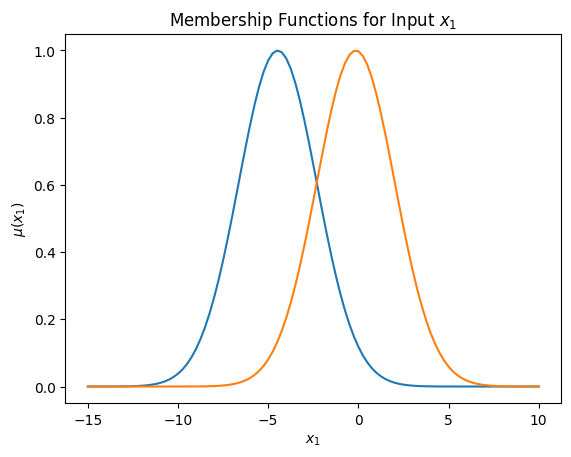

In [ ]:
x = np.linspace(-15, 10, 101)
plt.plot(x, evalmf(inmf[0][0], x))
plt.plot(x, evalmf(inmf[0][1], x))
plt.xlabel('$x_1$')
plt.ylabel('$\mu(x_1)$')
plt.title('Membership Functions for Input $x_1$')

Text(0.5, 1.0, 'Membership Functions for Input $x_2$')

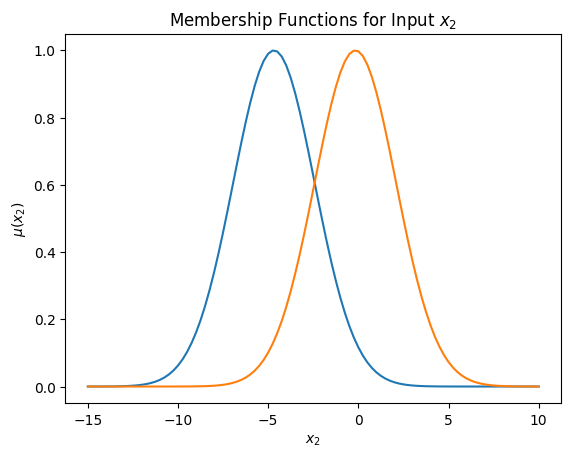

In [ ]:
plt.plot(x, evalmf(inmf[1][0], x))
plt.plot(x, evalmf(inmf[1][1], x))
plt.xlabel('$x_2$')
plt.ylabel('$\mu(x_2)$')
plt.title('Membership Functions for Input $x_2$')

Text(0.5, 1.0, 'Membership Functions for Output $y_1$')

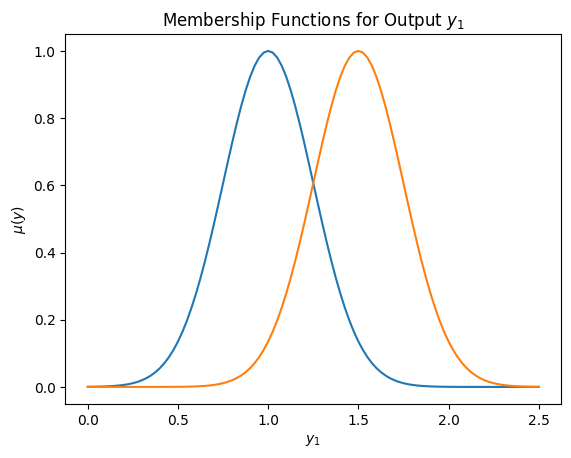

In [ ]:
y = np.linspace(0, 2.5, 101)
plt.plot(y, evalmf(outmf[0][0], y))
plt.plot(y, evalmf(outmf[0][1], y))
plt.xlabel('$y_1$')
plt.ylabel('$\mu(y)$')
plt.title('Membership Functions for Output $y_1$')

<font color=red>Question 2(a)</font>: Modify the span_learnmem to include a parameter called tail. If parameter is true, then all the membership functions generated will cover the universe of discourse. <font color=blue>Hint: One end of the left most and the other end of the right most membership function will give a membership value of 1, but not the middle of the membership function. </font><font color='red'>(0.5 mark)</font>

In [ ]:
# Modify the below code here for Question 2(a).
def span_learnmem1(x, params):

    assert len(params) == 3, 'spam_learnmem1 function must have 3 parameters.'
    nlabels, width, tail = np.asarray(params)
    nlabels=int(nlabels)
    tail=bool(tail)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)

    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)
    fis=[]
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
        sig=(centroids[1]-centroids[0])*width
        mf=[]
        for j in range(nlabels):
            if tail and j == 0:
              mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, -15, sig, centroids[j]]))
            elif tail and j == nlabels - 1:
              mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, 10]))
            else:
              mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)
    return fis


<font color=red>Question 2(b)</font>: Use the above modified span_learnmem and plot nlabels=5 membership functions with tail=true for $x_2$ <font color='red'>(0.5 mark)</font>

N_inputs= 2
N_rules= 25
N_output_mf= 5
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0 0.0 0.0  
1 0 1 0.0 0.0 0.0 0.0 0.0  
2 0 2 0.0 0.0 0.0 0.0 0.0  
3 0 3 0.0 0.0 0.0 0.0 0.0  
4 0 4 0.0 0.0 0.0 0.0 0.0  
5 1 0 0.0 0.0 0.0 0.0 0.0  
6 1 1 0.0 0.0 0.0 0.0 0.0  
7 1 2 0.0 0.0 0.0 0.0 0.0  
8 1 3 0.0 0.0 0.0 0.0 0.0  
9 1 4 0.0 0.0 0.0 0.0 0.0  
10 2 0 0.0 0.0 0.0 0.0 0.0  
11 2 1 0.0 0.0 0.0 0.0 0.0  
12 2 2 0.0 0.0 0.0 0.0 0.0  
13 2 3 0.0 0.0 0.0 0.0 0.0  
14 2 4 0.0 0.0 0.0 0.0 0.0  
15 3 0 0.0 0.0 0.0 0.0 0.0  
16 3 1 0.0 0.0 0.0 0.0 0.0  
17 3 2 0.0 0.0 0.0 0.0 0.0  
18 3 3 0.0 0.0 0.0 0.0 0.0  
19 3 4 0.0 0.0 0.0 0.0 0.0  
20 4 0 0.0 0.0 0.0 0.0 0.0  
21 4 1 0.0 0.0 0.0 0.0 0.0  
22 4 2 0.0 0.0 0.0 0.0 0.0  
23 4 3 0.0 0.0 0.0 0.0 0.0  
24 4 4 0.0 0.0 0.0 0.0 0.0  


Text(0.5, 1.0, 'Membership Functions for Input $x_2$')

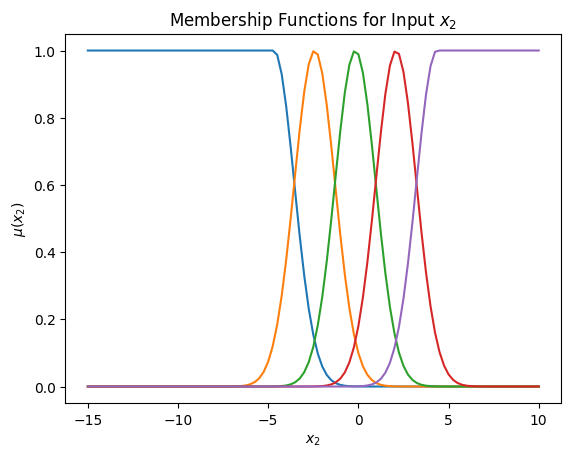

In [ ]:
# Enter code here for Question 2(b).
inmf3 = span_learnmem1(dataset, [5, 0.5, True])
outmf3 = span_learnmem1(labels, [5, 0.5, True])
nf3=popfnn(In_mf=inmf3, Out_mf=outmf3)
nf3.printruleslabels()

x = np.linspace(-15, 10, 101)
plt.plot(x, evalmf(inmf3[1][0], x))
plt.plot(x, evalmf(inmf3[1][1], x))
plt.plot(x, evalmf(inmf3[1][2], x))
plt.plot(x, evalmf(inmf3[1][3], x))
plt.plot(x, evalmf(inmf3[1][4], x))
plt.xlabel('$x_2$')
plt.ylabel('$\mu(x_2)$')
plt.title('Membership Functions for Input $x_2$')

<font color=red>Question 3(a)</font>: Now modify span_learnmem2 below without the width parameter and automatically compute the width such that the membership functions intersect at value $\mu=0.5$ between the centroids. Retain the tail parameter. <font color='red'>(0.5 mark)</font>

In [ ]:
# This function creates nlabels number of gauss2mf that spans min and max of the inputs
def span_learnmem2(x, params):

    assert len(params) == 2, 'spam_learnmem function must have 2 parameters.'
    nlabels, tail = np.asarray(params)
    nlabels=int(nlabels)
    tail=bool(tail)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)

    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)

    fis=[]
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
        sig=np.sqrt(-pow(((centroids[1]-centroids[0])*0.5), 2) / (2 * np.log(0.5)))
        mf=[]
        for j in range(nlabels):
            if tail and j == 0:
              mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, -15, sig, centroids[j]]))
            elif tail and j == nlabels - 1:
              mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, 10]))
            else:
              mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)
    return fis

<font color=red>Question 3(b)</font>: Use the above modified span_learnmem and plot nlabels=3 membership functions with tail=true for $x_1$ <font color='red'>(0.5 mark)</font>

N_inputs= 2
N_rules= 9
N_output_mf= 3
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0  
1 0 1 0.0 0.0 0.0  
2 0 2 0.0 0.0 0.0  
3 1 0 0.0 0.0 0.0  
4 1 1 0.0 0.0 0.0  
5 1 2 0.0 0.0 0.0  
6 2 0 0.0 0.0 0.0  
7 2 1 0.0 0.0 0.0  
8 2 2 0.0 0.0 0.0  


Text(0.5, 1.0, 'Membership Functions for Input $x_1$')

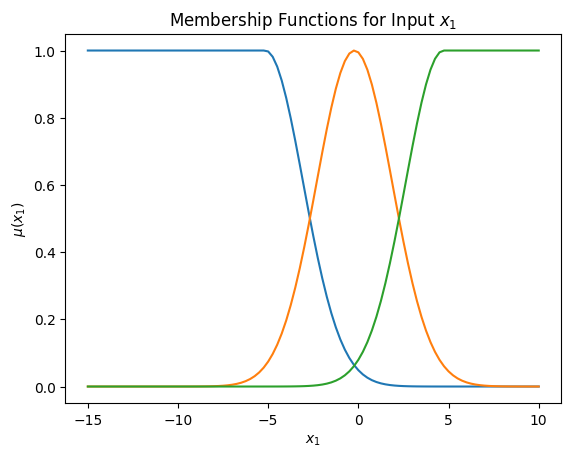

In [ ]:
# Enter code here for Question 3(b).
inmf4 = span_learnmem2(dataset, [3, True])
outmf4 = span_learnmem2(labels, [3, True])
nf3=popfnn(In_mf=inmf4, Out_mf=outmf4)
nf3.printruleslabels()

x = np.linspace(-15, 10, 101)
plt.plot(x, evalmf(inmf4[0][0], x))
plt.plot(x, evalmf(inmf4[0][1], x))
plt.plot(x, evalmf(inmf4[0][2], x))
plt.xlabel('$x_1$')
plt.ylabel('$\mu(x_1)$')
plt.title('Membership Functions for Input $x_1$')

<font color=red>Question 4</font>: Now create a new LVQ_learnmem with nlabels and tail parameters. Then plot nlabels=2 membership functions with tail=true for $x_2$. You can refer to code from AI6124 Assignment 3. Also automatically compute the width such that the membership functions intersect at value $\mu=0.5$ between the centroids<font color='red'> (1 mark)</font>

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 0.0 0.0  
1 0 1 0.0 0.0  
2 1 0 0.0 0.0  
3 1 1 0.0 0.0  


Text(0.5, 1.0, 'Membership Functions for Input $x_2$')

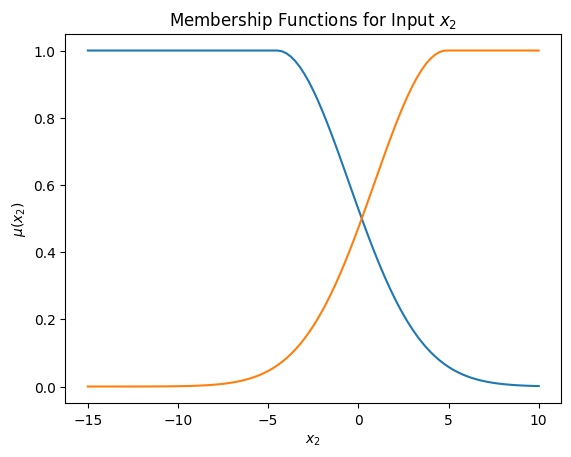

In [ ]:
# Enter code here for Question 4.
import numpy as np

def train_LVQ(traindata, weights):
    lrate=0.1
    epochs=100
    for epoch in range(epochs):
        rate = lrate * (1.0 - (epoch / float(epochs)))
        sum_error = 0.0
        for row in traindata:
            winner_index = find_winner(weights, row)
            error = (row - weights[winner_index])
            sum_error += np.sqrt(np.sum(error ** 2))
            weights[winner_index] += rate * error
    return weights

def find_winner(weights, test_sample):
    distances = list()
    for weight_index, weight in enumerate(weights):
        dist = np.sqrt(np.sum((weight-test_sample)**2))
        distances.append((weight_index, dist))
    distances.sort(key=lambda tuple: tuple[1])
    return distances[0][0]

def lvq_learnmem(x, params):
    assert len(params) == 2, 'lvq_learnmem function must have 2 parameters.'
    nlabels, tail = np.asarray(params)
    nlabels = int(nlabels)
    tail = bool(tail)

    maxx = np.amax(x, axis=0)
    minx = np.amin(x, axis=0)

    if x.ndim == 1:
        ninputs = 1
    else:
        ninputs = np.size(x, 1)

    fis = []
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
            centroids = train_LVQ(x, centroids)
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
        sig=np.sqrt(-pow(((centroids[1]-centroids[0])*0.5), 2) / (2 * np.log(0.5)))
        mf = []
        for j in range(nlabels):
            if tail and j == 0:
                mf.append(fuzzymf(Type='gauss2mf', Parameters=[sig, -15, sig, centroids[j]]))
            elif tail and j == nlabels - 1:
                mf.append(fuzzymf(Type='gauss2mf', Parameters=[sig, centroids[j], sig, 10]))
            else:
                mf.append(fuzzymf(Type='gauss2mf', Parameters=[sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)

    return fis

inmf5 = lvq_learnmem(dataset, [2, True])
outmf5 = lvq_learnmem(labels, [2, True])
nf4=popfnn(In_mf=inmf5, Out_mf=outmf5)
nf4.printruleslabels()

x = np.linspace(-15, 10, 101)
plt.plot(x, evalmf(inmf5[1][0], x))
plt.plot(x, evalmf(inmf5[1][1], x))
plt.xlabel('$x_2$')
plt.ylabel('$\mu(x_2)$')
plt.title('Membership Functions for Input $x_2$')

# 5. Train the POPFNN using POP learning

Next we train the POPFNN Neuro-Fuzzy System using Pseudo Outer-Product Learning algorithm. Becareful that you do not change some of the codes along the way. Check to ensure this code below produce only 4 if-then fuzzy rules before continue with the rest of the questions.

In [ ]:
# Perform POP learning
inmf = span_learnmem(dataset, [2, 0.5])
outmf = span_learnmem(labels, [2, 0.5])
nf=popfnn(In_mf=inmf, Out_mf=outmf)
for k in range(len(dataset)):
    nf.poplearn(dataset[k],labels[k])
nf.printruleslabels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 46.899487285044664 84.98513290579449  
1 0 1 49.06248223614986 40.021570275747436  
2 1 0 44.3016891219185 40.84242449947754  
3 1 1 77.1581639460343 38.749140026677935  


<font color=red>Question 5</font>: Examine the pseudo weights (pweights) for each output label in the output above. At the end of POP learning, each pweight corresponds to the respective outputs. Create a function in POPFNN class call identify_rules to identify the consequent for each rule based on the value of the pweights. <font color=blue>Hint: You just need to print the rule_number and the consequent. </font><font color='red'>(1 mark)</font>

In [ ]:
# Modify code in POPFNN class for Question 5
# Code to print rules for Question 5
nf.identify_rules()

rule number:  0, consequents: y2
rule number:  1, consequents: y1
rule number:  2, consequents: y1
rule number:  3, consequents: y1


<font color=red>Question 6</font>: Now create a function call print_int_labels in POPFNN class to print fuzzy if-then rules in an interpretable form with the consequent identified from question 5 above. <font color=blue>Hint: The if-then fuzzy rule printed should be in the form: "Rule 0: If x1 is small and x2 is large Then y is blue".</font><font color='red'>(1 mark)</font>  

In [ ]:
# Code to print interpretable rules for Question 8.
nf.print_int_labels()

Rule 0:if X1 is 0 and X2 is 0 then y is 2
Rule 1:if X1 is 0 and X2 is 1 then y is 1
Rule 2:if X1 is 1 and X2 is 0 then y is 1
Rule 3:if X1 is 1 and X2 is 1 then y is 1


<font color=red>Question 7</font>: Now change the generation of membership function to LVQ with nlabels=2 and tail=true. Retrain the fuzzy rules and print the rules for inspection. Any changes in the interpretable rules identified? <font color='red'>(1 mark)</font>

In [ ]:
# Enter code for Question 7
inmf = lvq_learnmem(dataset, [2, True])
outmf = lvq_learnmem(labels, [2, True])
nf=popfnn(In_mf=inmf, Out_mf=outmf)
for k in range(len(dataset)):
    nf.poplearn(dataset[k],labels[k])
nf.printruleslabels()

# Code to print interpretable rules for Question 7
nf.print_int_labels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 26.03769787171412 73.60324326189269  
1 0 1 28.369555813587976 26.059970268913894  
2 1 0 30.44228379703487 26.875230222629856  
3 1 1 68.87455422874744 23.06287363374793  
Rule 0:if X1 is 0 and X2 is 0 then y is 2
Rule 1:if X1 is 0 and X2 is 1 then y is 1
Rule 2:if X1 is 1 and X2 is 0 then y is 1
Rule 3:if X1 is 1 and X2 is 1 then y is 1


Enter your answer to Question 7 here. [Answer Yes or No]
 No

<font color=red>Question 8</font>: Now inspect the pseudo weights again. Some of the rules have pseudo weights that are very similar for both output labels. Implement another function to identify the more significant rules such that the pseduo weight for a particular output label is much higher than the other output labels. <font color=blue>Hint: How significant the rule is depends on a parameter that can be specified.You can specify this parameter. Examine the pweights carefully. Hints will also be mentioned in lecture.</font><font color='red'>(1 mark)</font>

In [ ]:
# Enter code for Question 8.
def print_significant_rules(rules):
    for i in range(rules.N_rules):
        if (rules.pweights[i][0] > 1.25 * rules.pweights[i][1]) or (rules.pweights[i][1] > 1.25 * rules.pweights[i][0]):
          consequent = np.argmax(rules.pweights[i])
          print("Rule", i, end =":")
          print("if X1 is" ,nf.getlabel(i,0), end=" and ")
          print("X2 is" ,nf.getlabel(i,1), end=" then ")
          print("y is", consequent+1)


print_significant_rules(nf)


Rule 0:if X1 is 0 and X2 is 0 then y is 2
Rule 3:if X1 is 1 and X2 is 1 then y is 1


<font color=red>Question 9</font>: Now implement a function in POPFNN class to predict the label y using the learned if-then-fuzzy rules. Use the optimized rules after question 8 above. However, if you are unable to answer question 8 above, you can use the unoptimized rules, but you have to indicate so in the answers.<font color=blue>Hint: You have to implement Compositional Rule of Inference (CRI) using the inputs values, the input membership function, and the output membership function. For defuzzification, you can use the Centre of Area for  Gaussian output membership function, which is just the Singleton value for the centroid of the output membership function.</font><font color='red'> (2 marks)</font>

In [ ]:
# Code for Question 9
seed(1234)
testdataset = np.random.randn(4,2)
testdataset[0:2]+=(+2)
testdataset[3:4]+=(-2)
predicted_y=nf.poppredict(testdataset)
print(predicted_y)


[[ 1.02300974  2.75254582]
 [ 2.51874296  4.28763745]
 [-0.04251183 -0.34301131]
 [-1.69131105 -0.70071287]]
[1, 2, 2, 1]
